<a href="https://colab.research.google.com/github/MiladNlpAi/hate-speech-offensive-detection-NLP-RNN-GRU/blob/main/hate_speech_detection_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# 1. Load Dataset
dataset = load_dataset("tdavidson/hate_speech_offensive")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24783 [00:00<?, ? examples/s]

In [3]:
df = pd.DataFrame(dataset['train'])
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [62]:
# Labels -> one-hot encoding
df = df[['class', 'tweet']]
labels = df['class'].tolist()
y = to_categorical(labels, num_classes=3)

In [17]:
# 2. Text Cleaning Functions
def clean_raw_tweet(text):
  text = text.lower()
  text = re.sub(r"http\s+", " ", text)
  text = re.sub(r"@\w+", " ", text)
  text = re.sub(r"#\w+", " ", text)
  text = re.sub(r"[^a-zA-Z\s]", " ", text)
  text = re.sub(r"\s+", " ", text).strip()
  return text


In [20]:
# Load SpaCy English model (only tokenizer + lemmatizer)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "rextcat"])

def clean_with_spacy(text):
  text = clean_raw_tweet(text)
  doc = nlp(text)
  tokens = [tok.lemma_ for tok in doc if not tok.is_stop and tok.is_alpha and len(tok) > 2]

  return " ".join(tokens)

# Apply preprocessing
texts = df['tweet'].astype(str).apply(clean_with_spacy).tolist()

In [21]:
# 3. Tokenization & Padding
MAX_WORDS = 20000  # maximum vocabulary size
MAX_LEN = 100      # maximum sequence length

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>") # <OOV> = Out Of Vocab
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_LEN)
print(X)

[[    0     0     0 ...    17    26    13]
 [    0     0     0 ...    57     3   305]
 [    0     0     0 ...   190  1225    11]
 ...
 [    0     0     0 ...     5    81   204]
 [    0     0     0 ...     2  1440   146]
 [    0     0     0 ... 18509     4 18510]]


In [63]:
# 4. Train/Validation/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [67]:
# 5. Build GRU Model

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(3, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [70]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.build(input_shape=(None, MAX_LEN))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,642,947 (10.08 MB)

 Trainable params: 2,642,947 (10.08 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
# 6. Compute Class Weights (to handle imbalance)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_integers = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_integers),
    y=y_integers
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(5.774433656957929), 1: np.float64(0.43049121791160005), 2: np.float64(1.9845400956512067)}


In [85]:
# 7. Callbacks (EarlyStopping + Checkpoint)
checkpoint = ModelCheckpoint(
    filepath = "best_model_word.h5",
    monitor = "val_accuracy",
    save_best_only = True,
    mode ="max",
    verbose = 1
)

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    patience = 3,
    restore_best_weights = True,
    verbose = 1
)

# 8. Train Model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9413 - loss: 0.1671
Epoch 1: val_accuracy improved from -inf to 0.89511, saving model to best_model_word.h5


279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9413 - loss: 0.1671 - val_accuracy: 0.8951 - val_loss: 0.3240
Epoch 2/20
277/279 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9614 - loss: 0.1110
Epoch 2: val_accuracy did not improve from 0.89511
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9614 - loss: 0.1111 - val_accuracy: 0.8946 - val_loss: 0.3827
Epoch 3/20
278/279 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9711 - loss: 0.0865
Epoch 3: val_accuracy did not improve from 0.89511
279/279 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9711 - loss: 0.0866 - val_accuracy: 0.8880 - val_loss: 0.4146
Epoch 4/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9777 - loss: 0.0706
Epoch 4: val_accuracy did not improve from 0.89511
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9777 - loss: 0.0706 - val_accuracy: 0.8875 - val_loss: 0.5100
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [86]:
# 9. Evaluate Model
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [87]:
target_names = ["hate speech", "offensive language", "neither"]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


Classification Report:
                    precision    recall  f1-score   support

       hate speech       0.43      0.31      0.36       286
offensive language       0.93      0.94      0.94      3838
           neither       0.82      0.85      0.84       833

          accuracy                           0.89      4957
         macro avg       0.73      0.70      0.71      4957
      weighted avg       0.88      0.89      0.89      4957



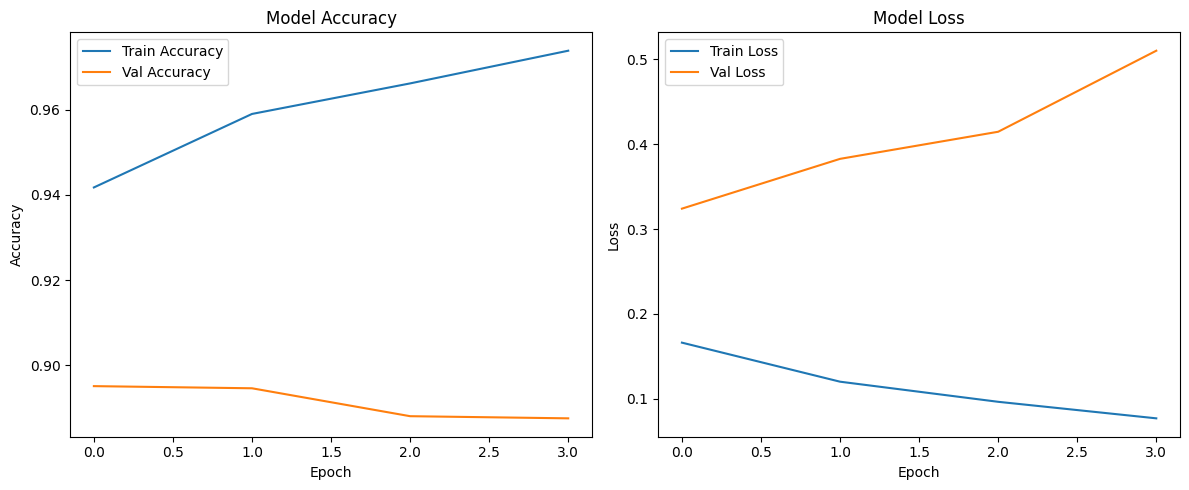

In [88]:
# 10. Plot Accuracy & Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
# 11. Load Best Model and Test on New Sentences
from tensorflow.keras.models import load_model
best_model = load_model("best_model_word.h5")

In [97]:
sentences = [
    "i love you!",
    "you are look like shit",
    "go away, everybody hate you"
]

seqs = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(seqs, maxlen=MAX_LEN)

preds = best_model.predict(padded)

idx2class = {0: "hate speech", 1: "offensive language", 2: "neither"}

for i, s in enumerate(sentences):
    class_idx = preds[i].argmax()
    print(f"\nSentence: {s}")
    print("Predicted Label:", idx2class[class_idx])
    print("Probabilities:", preds[i])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step

Sentence: i love you!
Predicted Label: neither
Probabilities: [0.01081967 0.07699221 0.9121881 ]

Sentence: you are look like shit
Predicted Label: offensive language
Probabilities: [0.08633968 0.90458894 0.00907138]

Sentence: go away, everybody hate you
Predicted Label: neither
Probabilities: [0.14688936 0.20905824 0.6440524 ]
